In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import copy
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=10_000)

In [3]:
df1 = pd.read_csv('datasets/bcsc_risk_factors_expanded1.csv')
df2 = pd.read_csv('datasets/bcsc_risk_factors_expanded2.csv')
df3 = pd.read_csv('datasets/bcsc_risk_factors_expanded3.csv')

In [4]:
#slight cleaning
df = pd.concat([df1, df2, df3])
df = df[df.ne(9).all(1)] #drop unknowns (9s)
df.drop(['year'], axis=1, inplace=True)

In [5]:
history_counts = df.breast_cancer_history.value_counts()
history_counts[1]/history_counts.sum()

0.05776633277910702

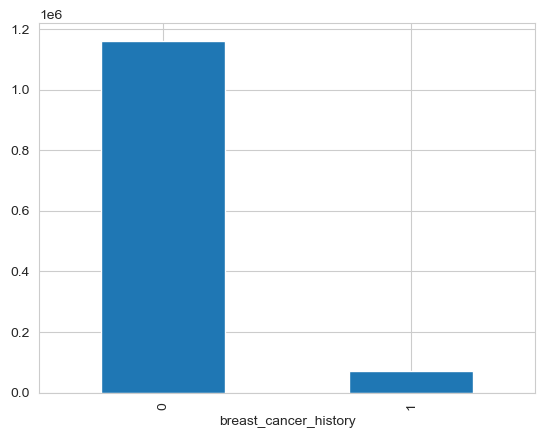

In [7]:
history_counts.plot(kind='bar')
plt.savefig('bch.png')

## We have about 5.7% 1s, this is a rare event

# Pytorch NN, Confusion Matrix, and Predict Proba

In [5]:
X = df.iloc[:, 0:df.shape[1]-1]
y = df.iloc[:, df.shape[1]-1]

In [6]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
X_test_balanced, y_test_balanced = smote.fit_resample(X_test_scaled, y_test)

In [7]:
y_df = pd.DataFrame(y_train_balanced)
y_df.breast_cancer_history.value_counts()

breast_cancer_history
0    813257
1    813257
Name: count, dtype: int64

In [8]:
# convert data to Pytorch tensors and move it to GPU
X_train = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train = torch.tensor(y_train_balanced.values, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [9]:
y_test

tensor([0., 0., 0.,  ..., 0., 1., 0.])

In [10]:
class NeuralNet(nn.Module):

  def __init__(self, input_size, hidden_size):
    super(NeuralNet, self).__init__()
    self.hidden1 = nn.Linear(input_size, hidden_size)
    self.relu1 = nn.ReLU()
    self.hidden2 = nn.Linear(hidden_size, input_size)
    self.relu2 = nn.ReLU()
    self.output = nn.Linear(input_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu1(self.hidden1(x))
    x = self.relu2(self.hidden2(x))
    x = self.sigmoid(self.output(x))
    #out = self.fc1(x)
    #out = self.relu(out)
    #out = self.fc2(out)
    #out = self.sigmoid(out)
    return x

In [11]:
class Deep(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Deep, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, input_size)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(input_size, hidden_size)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [12]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(10, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [21]:
#define hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
learning_rate = .0001
num_epochs = 150

In [25]:
# initialize the neural network and move it the GPU
#model = NeuralNet(input_size, hidden_size)
model = Deep(input_size, hidden_size)
#model = BinaryClassification()

In [26]:
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
losses = []
running_loss = 0.0

for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  #batch = X_train[idx: idx + batch_size]
  outputs = model(X_train)
  loss = criterion(outputs, y_train.unsqueeze(1))
  
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  running_loss += loss.item()

  # calculate accuracy
  with torch.no_grad():
    predicted = outputs.round()
    torch.set_printoptions(threshold=10_000)
    #print(predicted.abs().sum().item() == 0)
    #print(predicted)
    correct = (predicted == y_train.view(-1,1)).float().sum()
    accuracy = correct/y_train.size(0)
      
  #print(model.predict([1.0]))
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss : {loss.item():.4f}, Accuracy: {accuracy.item() * 100:.2f}%')

Epoch [1/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [2/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [3/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [4/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [5/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [6/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [7/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [8/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [9/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [10/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [11/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [12/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [13/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [14/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [15/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [16/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [17/150], Loss : 0.6954, Accuracy: 50.00%
Epoch [18/150], Loss : 0.6954, Accuracy: 50.00%


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss_vs_epochs.png')


In [1910]:
model.eval()
with torch.no_grad():
  outputs = model(X_train)
  predicted = outputs.round()
  correct = (predicted == y_train.view(-1,1)).float().sum()
  accuracy = correct/y_train.size(0)
  print(f'Accuracy on training data: {accuracy.item() * 100:.2f}%')

Accuracy on training data: 77.36%


In [1911]:

# evaluation on test set
model.eval()
with torch.no_grad():
  outputs = model(X_test)
  predicted = outputs.round()
  correct = (predicted == y_test.view(-1,1)).float().sum()
  accuracy = correct/y_test.size(0)
  print(f'Accuracy on test data: {accuracy.item() * 100:.2f}%')

Accuracy on test data: 75.93%


In [1912]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model_f, X_test_tensor_f, y_test_tensor_f):
    # Set the model to evaluation mode
    model_f.eval()

    # Get predictions
    with torch.no_grad():
        y_pred = model_f(X_test_tensor_f)
        y_pred_class = y_pred.round()

    # Convert tensors to numpy arrays
    y_true = y_test_tensor_f.numpy()
    y_pred = y_pred_class.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.show()
    plt.savefig('Confusion_Matrix.png')

    # Print classification report
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86    348470
         1.0       0.17      0.79      0.27     21415

    accuracy                           0.76    369885
   macro avg       0.57      0.77      0.57    369885
weighted avg       0.94      0.76      0.82    369885



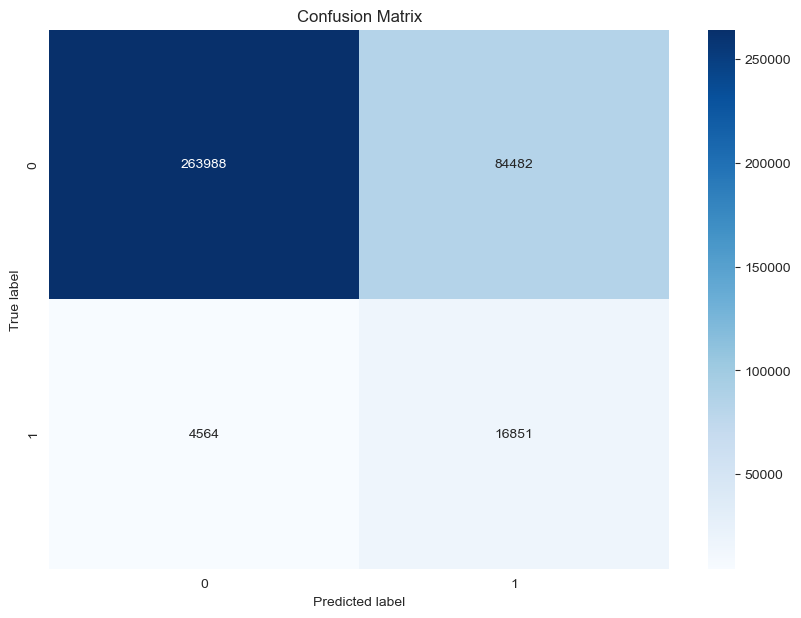

In [1913]:
plot_confusion_matrix(model, X_test, y_test)


In [1686]:
def predict_proba(model, features):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Convert features to a PyTorch tensor
        if isinstance(features, np.ndarray):
            features = torch.FloatTensor(features)
        elif isinstance(features, pd.DataFrame):
            features = torch.FloatTensor(features.values)
        
        # Ensure features is 2D
        if features.dim() == 1:
            features = features.unsqueeze(0)
        
        # Get the raw output (logits) from the model
        logits = model(features)
        
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        
        # Return probabilities for both classes
        return torch.cat([1 - probs, probs], dim=1)

In [1693]:
# For a single row
single_row = X.iloc[0]  # Get the first row of your features
scaled_row = scaler.transform(single_row.values.reshape(1, -1))
probabilities = predict_proba(model, scaled_row)
print(f"Probabilities for single row: {probabilities.numpy()}")


Probabilities for single row: [[0.4949538 0.5050462]]


In [1702]:
y_df = pd.DataFrame(y, columns=['breast_cancer_history']) 

In [1703]:
y_df.index[y_df['breast_cancer_history'] == 1].tolist()

[71223,
 71224,
 71225,
 71226,
 71227,
 71228,
 71229,
 71230,
 71231,
 71232,
 71233,
 71234,
 71235,
 71236,
 71237,
 71238,
 71239,
 71240,
 71241,
 71242,
 71243,
 71244,
 71245,
 71246,
 71247,
 71248,
 71249,
 71250,
 71251,
 71252,
 71253,
 71254,
 71255,
 71256,
 71257,
 71258,
 71259,
 71260,
 71261,
 71262,
 71263,
 71264,
 71265,
 71266,
 71267,
 71268,
 71269,
 71270,
 71271,
 71272,
 71273,
 71274,
 71275,
 71276,
 71277,
 71278,
 71279,
 71280,
 71281,
 71282,
 71283,
 71284,
 71285,
 71286,
 71287,
 71288,
 71289,
 71290,
 71291,
 71292,
 71293,
 71294,
 71295,
 71296,
 71297,
 71298,
 71299,
 71300,
 71301,
 71302,
 71303,
 71304,
 71305,
 71306,
 71307,
 71308,
 71309,
 71310,
 71311,
 71312,
 71313,
 71314,
 71315,
 71316,
 71317,
 71318,
 71319,
 71320,
 71321,
 71322,
 71323,
 71324,
 71325,
 71326,
 71327,
 71328,
 71329,
 71330,
 71331,
 71332,
 71333,
 71334,
 71335,
 71336,
 71337,
 71338,
 71339,
 71340,
 71341,
 71342,
 71343,
 71344,
 71345,
 71346,
 71347,


In [1706]:
single_row = X.iloc[71960]
print(single_row)
scaled_row = scaler.transform(single_row.values.reshape(1, -1))
probabilities = predict_proba(model, scaled_row)

print("Probabilities for single row:")
print(f"Class 0 (No breast cancer history): {probabilities[0, 0].item():.4f}")
print(f"Class 1 (Breast cancer history): {probabilities[0, 1].item():.4f}")

# Determine the predicted class
predicted_class = probabilities.argmax(dim=1).item()
print(f"\nPredicted class: {predicted_class}")

# Compare to actual target
actual_class = y.iloc[71960]
print(f"Actual class: {actual_class}")

# Print interpretation
print("\nInterpretation:")
if predicted_class == 1:
    print(f"The model predicts a {probabilities[0, 1].item()*100:.2f}% chance of breast cancer history.")
else:
    print(f"The model predicts a {probabilities[0, 0].item()*100:.2f}% chance of no breast cancer history.")

age_group_5_years        10
race_eth                  1
first_degree_hx           0
age_menarche              1
age_first_birth           3
BIRADS_breast_density     2
current_hrt               0
menopaus                  2
bmi_group                 3
biophx                    0
Name: 71960, dtype: int64
Probabilities for single row:
Class 0 (No breast cancer history): 0.3541
Class 1 (Breast cancer history): 0.6459

Predicted class: 1
Actual class: 1

Interpretation:
The model predicts a 64.59% chance of breast cancer history.


In [1710]:
import torch
import pandas as pd
import numpy as np

def create_feature_prediction_df(model, X_row, y_actual, scaler):
    """
    Create a DataFrame containing the features, predicted probabilities, and actual value for a single row.
    
    :param model: Trained PyTorch model
    :param X_row: Single row of features (pandas Series or DataFrame)
    :param y_actual: Actual target value
    :param scaler: Fitted StandardScaler used to preprocess the data
    :return: pandas DataFrame
    """
    # Ensure X_row is a DataFrame
    if isinstance(X_row, pd.Series):
        X_row = X_row.to_frame().T
    
    # Scale the features
    X_scaled = scaler.transform(X_row)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_scaled)
        logits = model(X_tensor)
        probs = torch.sigmoid(logits)
    
    # Create a dictionary to store all data
    data = {}
    
    # Add features to the dictionary
    for col in X_row.columns:
        data[col] = X_row[col].values[0]
    
    # Add predicted probabilities
    data['Prob_No_History'] = (1 - probs).item()
    data['Prob_History'] = probs.item()
    
    # Add actual value
    data['Actual_Value'] = y_actual
    
    # Create DataFrame
    df = pd.DataFrame([data])
    
    return df


In [1712]:
result_dfs = []
for i in range(500):
    X_single = X.iloc[i]
    y_single = y.iloc[i]
    df = create_feature_prediction_df(model, X_single, y_single, scaler)
    result_dfs.append(df)

# Combine all results into a single DataFrame
all_results = pd.concat(result_dfs, ignore_index=True)


In [1713]:
all_results

,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,Prob_No_History,Prob_History,Actual_Value
0,4,2,0,0,1,2,0,1,4,0,0.494954,0.505046,0
1,6,1,1,0,0,2,0,1,2,0,0.487165,0.512835,0
2,12,2,0,2,0,1,0,2,4,1,0.310825,0.689175,0
3,7,1,0,1,3,3,0,2,1,0,0.464111,0.535889,0
4,4,1,1,0,2,3,0,1,1,0,0.486442,0.513558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,3,0,1,1,2,0,1,2,0,0.471007,0.528993,0
496,5,1,0,1,3,3,0,1,1,0,0.491820,0.508180,0
497,5,2,0,0,0,2,0,1,4,0,0.476149,0.523851,0
498,13,1,0,0,3,2,1,2,2,0,0.454914,0.545086,0
